In [1]:
import numpy as np
import time
from sklearn.externals import joblib
from sklearn import model_selection
import itertools
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics


from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../')

from Sonar import StackedAutoEncoderCV as SAE

np.set_printoptions(3)

base_filename = '../Models/iris_sae_CLASS.jbl'

Using Theano backend.


# Load Data 

In [2]:
dataset = datasets.load_iris()
data = dataset.data
target = dataset.target
class_names = dataset['target_names']

# Novelty Definition 

In [3]:
nov_cls = 0
nov_data = data[target == nov_cls]
nov_target = target[target == nov_cls]
nov_name = class_names[nov_cls]
# Known data
data = data[target != nov_cls]
target = target[target != nov_cls]
if np.unique(target).shape[0] == 2:
    one_hot_target = np.ones([target.shape[0],1])
    one_hot_target[target == np.unique(target)[1], 0] = -1
else:
    one_hot_target = -np.ones([target.shape[0], np.unique(target).shape[0]])
    for i, cls in enumerate(np.unique(target)):
        one_hot_target[target == cls, i] = 1
class_names = np.setdiff1d(class_names, [nov_name])

# Load Models 

In [4]:
autoencoders = {}
encoders = {}
for cls in class_names:
    sae = SAE.StackedAutoEncoderCV()
    sae.load(base_filename.replace('CLASS', cls))
    autoencoders[cls] = sae.network
    encoders[cls] = sae.network.get_encoder()

Loading from  ../Models/iris_sae_versicolor.jbl


C:\ProgramData\Anaconda2\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading from  ../Models/iris_sae_virginica.jbl


# Add Output Classification Layer 

In [6]:
common_input = layers.Input(shape = [data.shape[1]])
graphs = []
for cls in encoders.keys():
    gr = common_input
    for lay in encoders[cls].layers:
        lay.name = 'class_'+ cls + lay.name
        lay.trainable = False
        gr = lay(gr)
    graphs.append(gr)
merge_layer = layers.concatenate(graphs, axis=1)
hidden_layer = layers.Dense(10, activation='tanh')(merge_layer)
out_layer = layers.Dense(one_hot_target.shape[1], activation='tanh')(hidden_layer)
new_model = models.Model(inputs=[common_input], outputs=out_layer)
opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
new_model.compile(loss='mean_squared_error', optimizer=opt)

trn_desc = new_model.fit(data, one_hot_target, 
                         epochs = 200, 
                         batch_size = 100,
                         verbose = False,
                         shuffle=False)

In [7]:
Y = new_model.predict(data)
Y = Y > 0
T = one_hot_target > 0
print metrics.accuracy_score(Y[T],T[T])
print metrics.accuracy_score(Y[~T],T[~T])
print metrics.accuracy_score(Y,T)

0.96
0.92
0.94


In [29]:
clsname = 'versicolor'
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 1]), data[target == 1])
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 2]), data[target == 2])
print metrics.mean_squared_error(autoencoders[clsname].predict(nov_data), nov_data)

0.0371959368318
0.365394208782
1.79865124692


In [13]:
clsname = 'virginica'
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 1]), data[target == 1])
print metrics.mean_squared_error(autoencoders[clsname].predict(data[target == 2]), data[target == 2])
print metrics.mean_squared_error(autoencoders[clsname].predict(nov_data), nov_data)

0.356742143723
0.0507086021637
4.08524442809


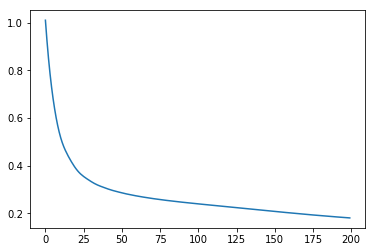

In [30]:
plt.plot(trn_desc.epoch, trn_desc.history['loss'], '-')

In [24]:
Y = new_model.predict(data)
print metrics.confusion_matrix(Y > 0, one_hot_target > 0)
print metrics.classification_report(Y > 0, one_hot_target > 0)

[[46  2]
 [ 4 48]]
             precision    recall  f1-score   support

      False       0.92      0.96      0.94        48
       True       0.96      0.92      0.94        52

avg / total       0.94      0.94      0.94       100



Class
Known      Axes(0.125,0.125;0.775x0.755)
Novelty    Axes(0.125,0.125;0.775x0.755)
Name: Output, dtype: object

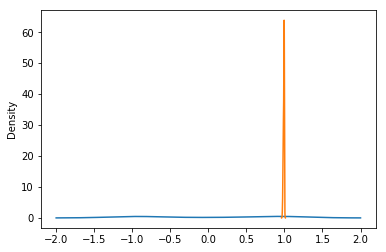

In [17]:
Y = new_model.predict(nov_data)
Y = np.max(Y, axis=1)

import pandas
df_known = pandas.DataFrame(columns=['Class','Output'])
df_known['Output'] = np.max(new_model.predict(data), axis=1)
df_known['Class'] = 'Known'
df_nov = pandas.DataFrame(columns=['Class','Output'])
df_nov['Output'] = np.max(new_model.predict(nov_data), axis=1)
df_nov['Class'] = 'Novelty'
df = pandas.concat((df_known, df_nov), axis=0)

df.groupby('Class').Output.plot(kind='kde')

Class
Novelty    Axes(0.125,0.125;0.775x0.755)
Name: Output, dtype: object

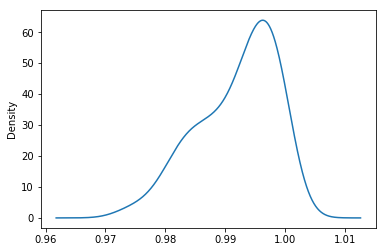

In [18]:
df_nov.groupby('Class').Output.plot(kind='kde')

(-1, 1)

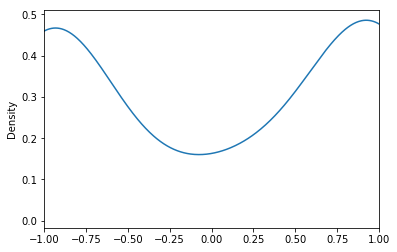

In [19]:
df_known.groupby('Class').Output.plot(kind='kde')
plt.xlim((-1, 1))

# Test With Classifier Class 

In [5]:
from Sonar import StackedAutoEncoderClassifier as SAEC


netclf = SAEC.StackedAutoEncoderClassifier(hidden = 10, optimizer = 'adam', nepochs = 200,
                                           batch_size=100, ninit = 1, verbose=True)
netclf.set_encoders(encoders)
netclf.fit(data, one_hot_target)


['loss']
Final Classification Accuracy (training)  : 2.166e-01
Training took 1 s


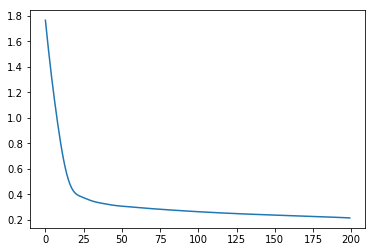

In [9]:
plt.plot(netclf.trn_info['epochs'], netclf.trn_info['loss'], '-')

In [10]:
Y = netclf.predict(data)
print metrics.confusion_matrix(Y > 0, one_hot_target > 0)
print metrics.classification_report(Y > 0, one_hot_target > 0)

[[46  2]
 [ 4 48]]
             precision    recall  f1-score   support

      False       0.92      0.96      0.94        48
       True       0.96      0.92      0.94        52

avg / total       0.94      0.94      0.94       100



In [6]:
netclf.label = 'h10'
netclf.save('../Models/test_network')

'../Models/test_network_h10'

In [8]:
nnet = SAEC.StackedAutoEncoderClassifier()
nnet.load('../Models/test_network_h10')
Y = netclf.predict(data)
print metrics.confusion_matrix(Y > 0, one_hot_target > 0)
print metrics.classification_report(Y > 0, one_hot_target > 0)

[[46  2]
 [ 4 48]]
             precision    recall  f1-score   support

      False       0.92      0.96      0.94        48
       True       0.96      0.92      0.94        52

avg / total       0.94      0.94      0.94       100

